In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

Cleaning Dataset

In [2]:
df = pd.read_csv('pollution_data.csv')
df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at'] = df['created_at'].dt.tz_localize(None)

df

,created_at,Temperature,Humidity,PM2.5,PM10,CO,CO2
0,2025-06-21 07:00:15,24.8,84.3,52.7,72.5,0.59860,403.34171
1,2025-06-21 07:01:04,24.8,84.1,50.4,66.7,0.56109,403.40472
2,2025-06-21 07:01:53,24.8,84.0,51.7,74.0,0.54466,403.36261
3,2025-06-21 07:02:43,24.9,83.6,49.7,65.9,0.55447,403.30020
4,2025-06-21 07:03:32,24.9,83.3,51.6,72.7,0.57113,403.29333
...,...,...,...,...,...,...,...
62420,2025-07-28 06:55:48,25.7,77.3,60.4,89.8,8.19941,411.28958
62421,2025-07-28 06:56:41,25.8,77.0,59.8,88.2,8.21437,411.35828
62422,2025-07-28 06:57:35,25.8,76.8,61.0,92.7,8.12498,411.18726
62423,2025-07-28 06:58:24,25.8,76.5,60.2,90.9,8.15468,411.41003


In [3]:
df = df.drop(columns=['Temperature', 'Humidity'])
df['created_at'] = df['created_at'].dt.floor('min')
df = df[df['created_at'].dt.minute % 3 == 0]
df = df.drop_duplicates(subset='created_at', keep='first')
df = df.rename(columns={'created_at':'datetime'})
df.set_index('datetime', inplace=True)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['minute'] = df.index.minute
df

,PM2.5,PM10,CO,CO2,hour,dayofweek,minute
datetime,,,,,,,
2025-06-21 07:00:00,52.7,72.5,0.59860,403.34171,7,5,0
2025-06-21 07:03:00,51.6,72.7,0.57113,403.29333,7,5,3
2025-06-21 07:06:00,50.2,67.4,0.55119,403.32782,7,5,6
2025-06-21 07:09:00,54.5,74.4,0.58302,403.24551,7,5,9
2025-06-21 07:12:00,55.0,72.6,0.53658,403.36960,7,5,12
...,...,...,...,...,...,...,...
2025-07-28 06:45:00,52.4,80.0,7.34412,410.49396,6,0,45
2025-07-28 06:48:00,53.6,84.1,7.20935,410.60675,6,0,48
2025-07-28 06:51:00,61.7,90.6,7.64829,410.65543,6,0,51


In [4]:
features = ['PM2.5', 'PM10', 'CO', 'CO2', 'hour', 'minute', 'dayofweek']
features_y = ['PM2.5', 'PM10', 'CO', 'CO2']
data_X = df[features].dropna()
data_y = df[features_y].dropna()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data_X)
y_scaled = scaler_y.fit_transform(data_y)

X_scaled.shape, y_scaled.shape

((17388, 7), (17388, 4))

In [5]:
joblib.dump(scaler_X, 'scaler_X.save')
joblib.dump(scaler_y, 'scaler_y.save')

['scaler_y.save']

In [26]:
def create_sequences(X_data, y_data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(X_data) - n_steps_in - n_steps_out + 1):
      X.append(X_data[i:i+n_steps_in])
      y.append(y_data[i+n_steps_in:i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

n_in = 20
n_out = 20

X, y = create_sequences(X_scaled, y_scaled, n_in, n_out)

X.shape,y.shape

((17349, 20, 7), (17349, 20, 4))

In [28]:
X.shape

(17349, 20, 7)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = X.shape[2]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13879, 20, 7), (3470, 20, 7), (13879, 20, 4), (3470, 20, 4))

In [8]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(n_in, n_features),))
model.add(RepeatVector(n_out))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(y.shape[2]))) # Changed to y.shape[2] to match the number of output features
model.summary()

c:\Users\Muhammad Mahdi\anaconda3\envs\prediksi-polusi\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 4)          │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,732 (788.02 KB)

 Trainable params: 201,732 (788.02 KB)

 Non-trainable params: 0 (0.00 B)

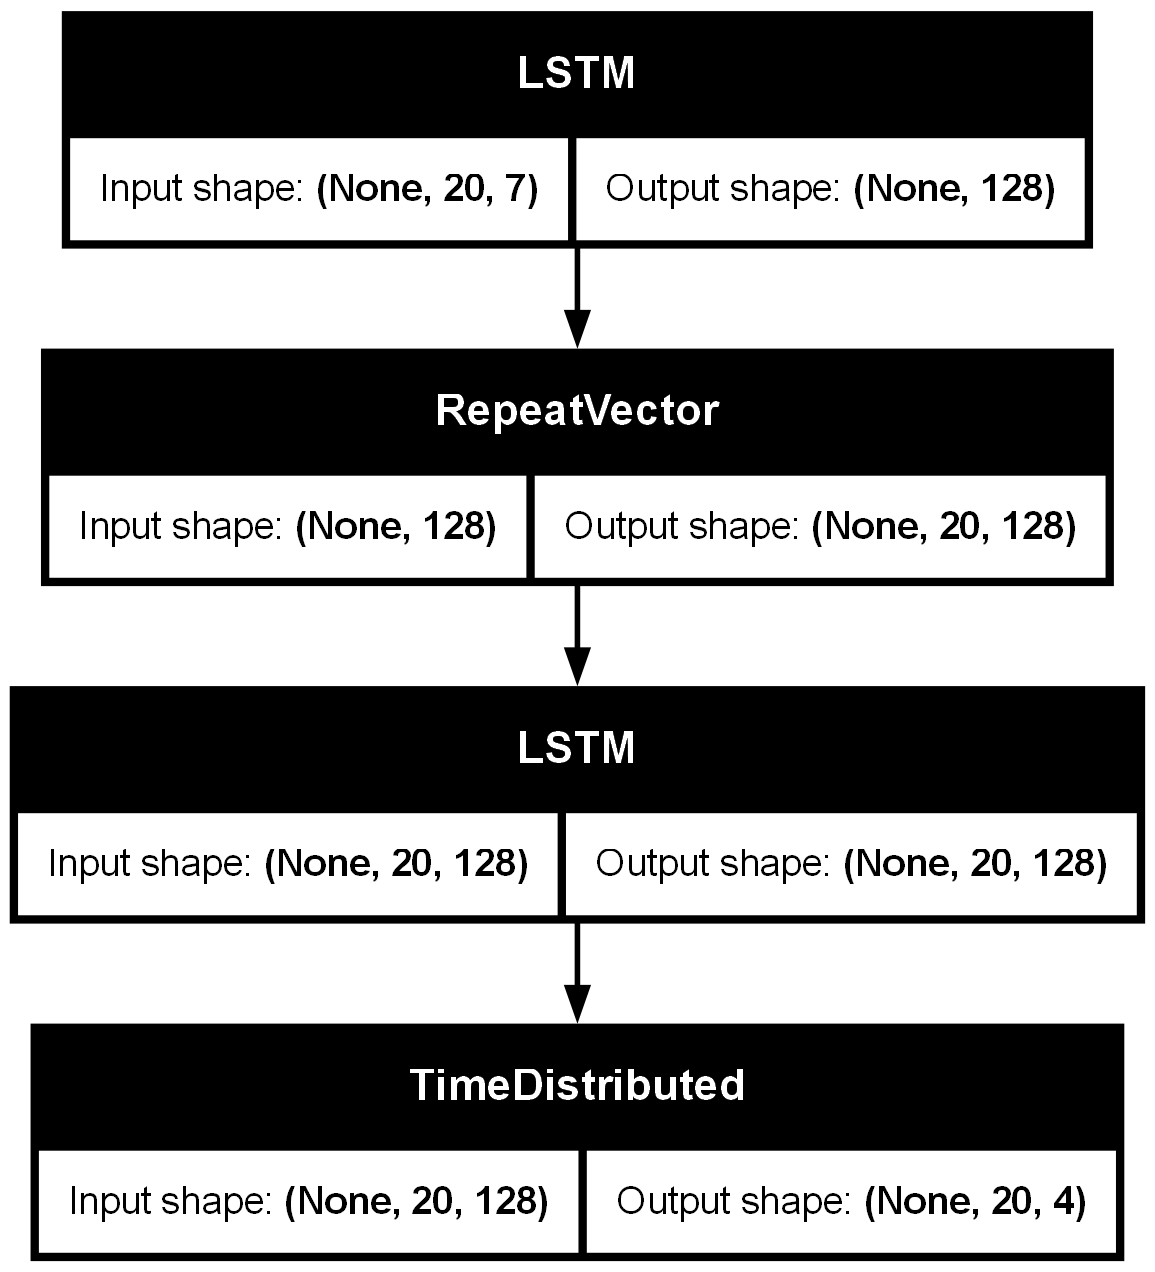

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
tf.random.set_seed(42)
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model.compile(optimizer='adam', loss=MeanSquaredError())

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0079 - val_loss: 0.0026
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 12/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
# model.save("lstm_model.h5")

In [11]:
model = load_model("lstm_model.h5", compile=False)

In [12]:
y_pred_scaled = model.predict(X_train).reshape(-1, y.shape[2])
y_true_scaled = y_train.reshape(-1, y.shape[2])

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

def modified_mape(y_true, y_pred, epsilon=1e-2):
    y_true = np.where(np.abs(y_true) < epsilon, epsilon, y_true)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

for i, name in enumerate(features_y):
    y_true_f = y_true[:, i]
    y_pred_f = y_pred[:, i]

    mae = mean_absolute_error(y_true_f, y_pred_f)
    rmse = np.sqrt(mean_squared_error(y_true_f, y_pred_f))
    mape = modified_mape(y_true_f, y_pred_f)
    r2 = r2_score(y_true_f, y_pred_f)
    acc = max(0, 100 - mape)

    print(f"🔍 Evaluasi untuk {name}")
    print(f"  MAE : {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}")
    print(f"  R²  : {r2:.2f}")
    print(f"  Acc : {acc:.2f}%")
    print("-" * 30)

434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
🔍 Evaluasi untuk PM2.5
  MAE : 5.05
  RMSE: 7.53
  MAPE: 21.92
  R²  : 0.92
  Acc : 78.08%
------------------------------
🔍 Evaluasi untuk PM10
  MAE : 8.25
  RMSE: 12.23
  MAPE: 25.77
  R²  : 0.91
  Acc : 74.23%
------------------------------
🔍 Evaluasi untuk CO
  MAE : 0.09
  RMSE: 0.14
  MAPE: 5.49
  R²  : 0.99
  Acc : 94.51%
------------------------------
🔍 Evaluasi untuk CO2
  MAE : 0.16
  RMSE: 0.24
  MAPE: 0.04
  R²  : 0.98
  Acc : 99.96%
------------------------------


In [13]:
train_pred_scaled = model.predict(X_train)
train_pred_scaled = train_pred_scaled.reshape(-1, y.shape[2]) # Reshape to 2D
train_pred = scaler_y.inverse_transform(train_pred_scaled)
y_train = y_train.reshape(-1, y.shape[2]) # Reshape to 2D
y_train_unscaled = scaler_y.inverse_transform(y_train)
train_results = pd.DataFrame({
    'Prediction': train_pred[:20].flatten(),
    'Actual': y_train_unscaled[:20].flatten()
})

train_results

434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


,Prediction,Actual
0,23.103373,31.10000
1,39.367153,57.00000
2,0.800256,1.33225
3,405.496002,407.31531
4,25.525730,28.60000
...,...,...
75,407.158203,407.15857
76,32.746738,27.50000
77,53.631390,38.10000
78,1.178663,1.35207


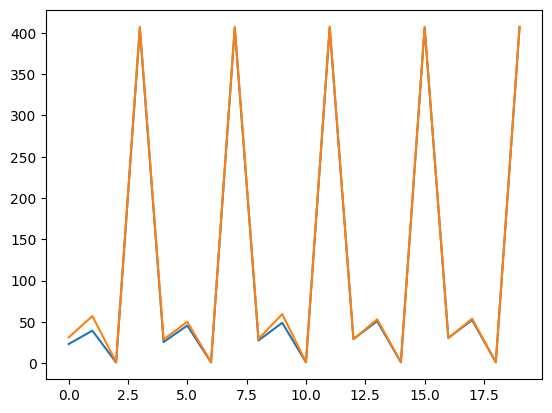

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_results['Prediction'][:20])
plt.plot(train_results['Actual'][:20])

[[ 23.103373    39.367153     0.8002565  405.496     ]
 [ 25.52573     45.523438     0.87443256 405.78607   ]
 [ 27.512207    48.826214     0.9437147  406.0647    ]
 ...
 [ 71.94982     99.494865     3.4643936  405.45804   ]
 [ 71.84365     99.49926      3.4671204  405.45398   ]
 [ 71.9503      99.910576     3.4721682  405.4529    ]]
[[ 31.1      57.        1.33225 407.31531]
 [ 28.6      50.        1.21812 407.34174]
 [ 29.3      59.4       1.35873 407.6785 ]
 ...
 [ 61.9      84.4       3.4548  405.33508]
 [ 68.6      93.2       3.27952 405.31741]
 [ 60.7      81.3       3.49078 405.33508]]


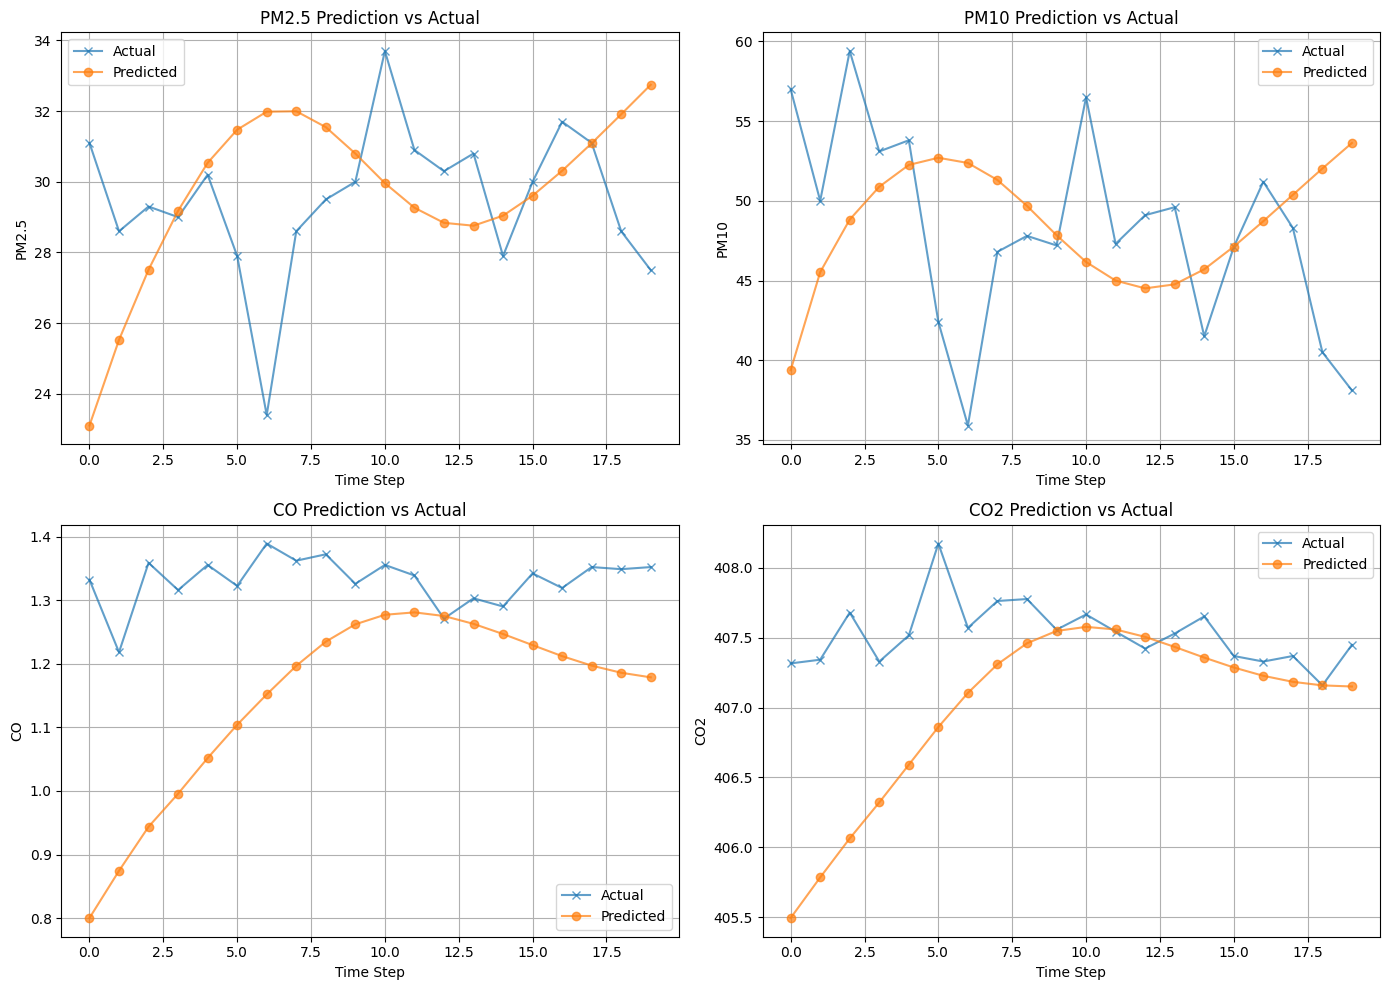

In [16]:
n_features = len(features_y)

plt.figure(figsize=(14, 10))

print(y_pred)
print(y_true)

for i in range(n_features):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true[:20, i], label='Actual', alpha=0.7, marker='x')
    plt.plot(y_pred[:20, i], label='Predicted', alpha=0.7, marker='o')
    plt.title(f'{features[i]} Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel(features[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
y_pred_scaled = model.predict(X_test).reshape(-1, y.shape[2])
y_true_scaled = y_test.reshape(-1, y.shape[2])

y_pred_test = scaler_y.inverse_transform(y_pred_scaled)
y_true_test = scaler_y.inverse_transform(y_true_scaled)

def modified_mape(y_true, y_pred, epsilon=1e-2):
    y_true = np.where(np.abs(y_true) < epsilon, epsilon, y_true)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

for i, name in enumerate(features_y):
    y_true_f = y_true[:, i]
    y_pred_f = y_pred[:, i]

    mae = mean_absolute_error(y_true_f, y_pred_f)
    rmse = np.sqrt(mean_squared_error(y_true_f, y_pred_f))
    mape = modified_mape(y_true_f, y_pred_f)
    r2 = r2_score(y_true_f, y_pred_f)
    acc = max(0, 100 - mape)

    print(f"🔍 Evaluasi untuk {name}")
    print(f"  MAE : {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}")
    print(f"  R²  : {r2:.2f}")
    print(f"  Acc : {acc:.2f}%")
    print("-" * 30)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
🔍 Evaluasi untuk PM2.5
  MAE : 5.31
  RMSE: 7.91
  MAPE: 18.57
  R²  : 0.92
  Acc : 81.43%
------------------------------
🔍 Evaluasi untuk PM10
  MAE : 8.69
  RMSE: 12.91
  MAPE: 21.29
  R²  : 0.90
  Acc : 78.71%
------------------------------
🔍 Evaluasi untuk CO
  MAE : 0.09
  RMSE: 0.14
  MAPE: 5.70
  R²  : 0.99
  Acc : 94.30%
------------------------------
🔍 Evaluasi untuk CO2
  MAE : 0.17
  RMSE: 0.25
  MAPE: 0.04
  R²  : 0.98
  Acc : 99.96%
------------------------------


In [18]:
test_pred_scaled = model.predict(X_test)
test_pred_scaled = test_pred_scaled.reshape(-1, y.shape[2]) # Reshape to 2D
test_pred = scaler_y.inverse_transform(test_pred_scaled)
y_test = y_test.reshape(-1, y.shape[2]) # Reshape to 2D
y_test_unscaled = scaler_y.inverse_transform(y_test)
test_results = pd.DataFrame({
    'Prediction': test_pred[:20].flatten(),
    'Actual': y_test_unscaled[:20].flatten()
})

test_results

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Prediction,Actual
0,33.098736,37.30000
1,54.848267,61.50000
2,1.598832,1.49316
3,402.867584,403.01010
4,34.138233,35.00000
...,...,...
75,403.233521,402.88699
76,34.976002,39.80000
77,56.134480,71.80000
78,1.769608,1.78825


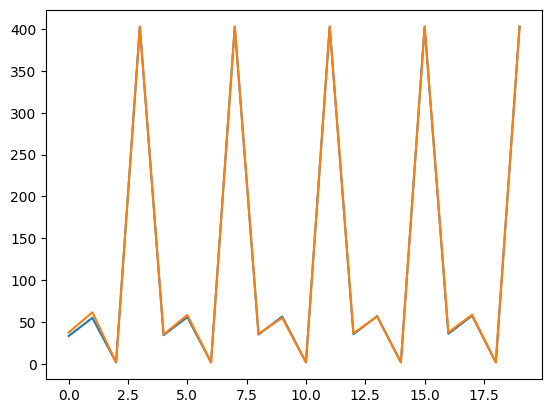

In [19]:
plt.plot(test_results['Prediction'][:20])
plt.plot(test_results['Actual'][:20])

[[ 33.098736    54.848267     1.598832   402.86758   ]
 [ 34.138233    55.699753     1.6140882  402.95514   ]
 [ 34.83351     56.37287      1.6226777  403.00165   ]
 ...
 [ 34.09784     48.94663      0.79525924 404.49698   ]
 [ 34.013313    48.7825       0.7961714  404.49554   ]
 [ 33.931763    48.630806     0.7969443  404.49414   ]]
[[ 37.3      61.5       1.49316 403.0101 ]
 [ 35.       58.3       1.55921 402.91339]
 [ 35.6      54.9       1.53694 403.03195]
 ...
 [ 37.8      54.9       0.83213 404.57703]
 [ 38.7      55.4       0.80535 404.60394]
 [ 38.4      56.4       0.85499 404.80545]]


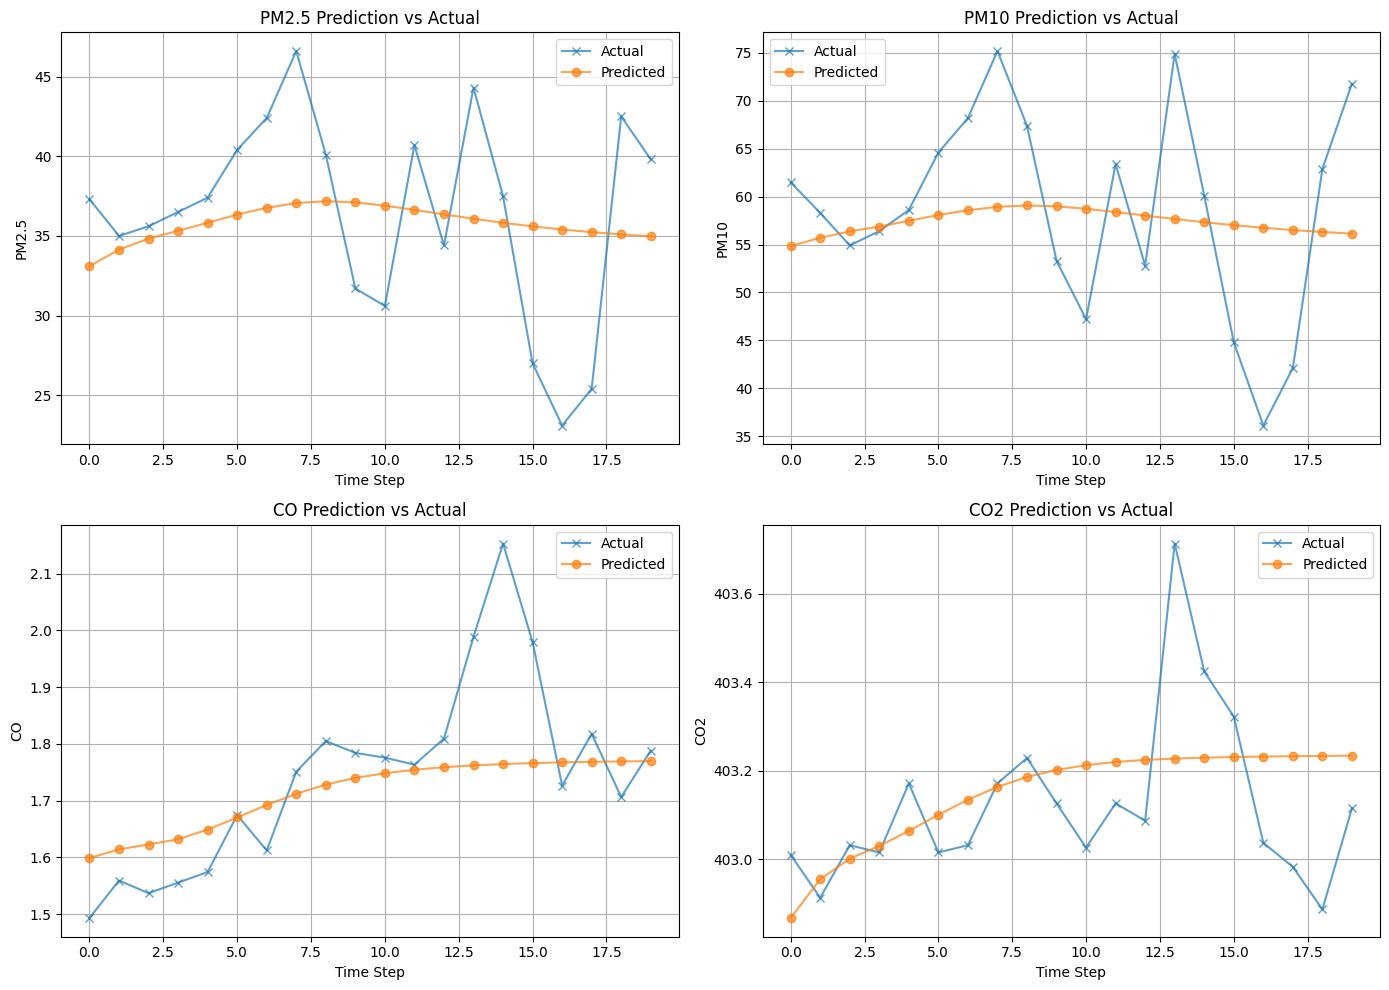

In [21]:
n_features = len(features_y)

plt.figure(figsize=(14, 10))

print(y_pred_test)
print(y_true_test)

for i in range(n_features):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true_test[:20, i], label='Actual', alpha=0.7, marker='x')
    plt.plot(y_pred_test[:20, i], label='Predicted', alpha=0.7, marker='o')
    plt.title(f'{features[i]} Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel(features[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()